In [3]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMRegressor
from utils.utils_models import LightGBMForecastingModel

import utils.utils_preprocessing as utils_preprocessing
from utils.utils_features import features_time_related, features_lag, create_periods_feature

### Load data

In [4]:
df_sales = pd.read_parquet("data/sales.parquet")
df_products = pd.read_parquet("data/products.parquet")
df = df_sales.merge(df_products, on="product_id")

### Preprocessing

In [5]:
df = utils_preprocessing.set_types(df)
df = utils_preprocessing.filter_dates(df, date="2024-09-01")

In [6]:
df_monthly = utils_preprocessing.aggregate_data(df, frequency="ME")
df_monthly = utils_preprocessing.fill_in_missing_dates(df_monthly, group_col=["brand", "family"], date_col="date", freq="ME")

In [7]:
df_monthly

,brand,family,date,total_revenue
0,Columbia,Bañadores Natación,2021-09-30,99.949997
1,Columbia,Bañadores Natación,2021-10-31,99.949997
2,Columbia,Bañadores Natación,2021-11-30,99.949997
3,Columbia,Bañadores Natación,2021-12-31,99.949997
4,Columbia,Bañadores Natación,2022-01-31,99.949997
...,...,...,...,...
3474,adidas,Zuecos Urban,2024-03-31,99.949997
3475,adidas,Zuecos Urban,2024-04-30,99.949997
3476,adidas,Zuecos Urban,2024-05-31,199.899994
3477,adidas,Zuecos Urban,2024-06-30,99.949997


### Features generation

In [8]:
df_monthly = features_time_related(df_monthly, frequency='ME')
df_monthly = features_lag(
    df=df_monthly, 
    col="total_revenue",
    lags=[12, 13, 14],
    group_column=['brand', 'family']
)
df_monthly = create_periods_feature(df_monthly, group_col=['brand', 'family'], date_col='date', target_col='total_revenue')

In [9]:
df_monthly

,brand,family,date,total_revenue,year,month_of_year,sin_month_of_year,cos_month_of_year,total_revenue_lag_12,total_revenue_lag_13,total_revenue_lag_14,feature_periods
0,Columbia,Bañadores Natación,2021-09-30,99.949997,2021,9,-1.000,-0.000,NaN,NaN,NaN,1.0
1,Columbia,Bañadores Natación,2021-10-31,99.949997,2021,10,-0.866,0.500,NaN,NaN,NaN,2.0
2,Columbia,Bañadores Natación,2021-11-30,99.949997,2021,11,-0.500,0.866,NaN,NaN,NaN,3.0
3,Columbia,Bañadores Natación,2021-12-31,99.949997,2021,12,-0.000,1.000,NaN,NaN,NaN,4.0
4,Columbia,Bañadores Natación,2022-01-31,99.949997,2022,1,0.500,0.866,NaN,NaN,NaN,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3474,adidas,Zuecos Urban,2024-03-31,99.949997,2024,3,1.000,0.000,99.949997,99.949997,99.949997,32.0
3475,adidas,Zuecos Urban,2024-04-30,99.949997,2024,4,0.866,-0.500,299.849976,99.949997,99.949997,33.0
3476,adidas,Zuecos Urban,2024-05-31,199.899994,2024,5,0.500,-0.866,299.849976,299.849976,99.949997,34.0
3477,adidas,Zuecos Urban,2024-06-30,99.949997,2024,6,0.000,-1.000,299.849976,299.849976,299.849976,35.0


### Hyperparameters evaluation

In [10]:
cols_categorical = ['brand', 'family']
for col in cols_categorical:
    df_monthly[col] = df_monthly[col].astype("category")
df_monthly = df_monthly.rename(columns={"total_revenue": "y"}).set_index("date")

In [11]:
X_train, X_test, y_train, y_test = utils_preprocessing.train_test_split(df_monthly, forecasting_horizon=12, target_col="y")

In [12]:
X_test.index.min(), X_test.index.max()

(Timestamp('2023-09-30 00:00:00'), Timestamp('2024-08-31 00:00:00'))

In [13]:
cv_split = TimeSeriesSplit(n_splits=3, test_size=12)

In [14]:
parameters = {
    'objective': ['regression'],
    "boosting_type": ["gbdt"],
    'metric': ['rmse'],
    'importance_type': ['split'],
    'verbosity': [-1],
    "max_depth": [-1, 1, 3, 4, 5, 6, 10],
    "num_leaves": [10, 20, 30, 40, 100, 120, 150, 200, 250],
    "learning_rate": [0.01, 0.1, 0.2, 0.3, 0.4, 0.5],
    "n_estimators": [50, 100, 300, 500, 700, 900, 1000],
    "colsample_bytree": [0.3, 0.5, 0.7, 1, 1.2, 1.5],
    "reg_alpha": [0, 0.01, 1, 2, 5, 7, 10, 50, 100],
    "reg_lambda": [0, 0.01, 1, 5, 10, 20, 50, 100]
}


random_search = RandomizedSearchCV(
    estimator=LGBMRegressor(), 
    cv=cv_split, 
    param_distributions=parameters,
    verbose=1
    )
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /Users/runner/work/LightGBM/LightGBM/lightgbm-python/src/io/config_auto.cpp, line 385 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /Users/runner/work/LightGBM/LightGBM/lightgbm-python/src/io/config_auto.cpp, line 385 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /Users/runner/work/LightGBM/LightGBM/lightgbm-python/src/io/config_auto.cpp, line 385 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /Users/runner/work/LightGBM/LightGBM/lightgbm-python/src/io/config_auto.cpp, line 385 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /Users/runner/work/LightGBM/LightGBM/lightgbm-python/src/io/config_auto.cpp, line 385 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /Users/runner/work/LightGBM/LightGBM/lightgbm-python/src/io/config_auto.cpp, line 385 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /Users/runner/work

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=12),
                   estimator=LGBMRegressor(),
                   param_distributions={'boosting_type': ['gbdt'],
                                        'colsample_bytree': [0.3, 0.5, 0.7, 1,
                                                             1.2, 1.5],
                                        'importance_type': ['split'],
                                        'learning_rate': [0.01, 0.1, 0.2, 0.3,
                                                          0.4, 0.5],
                                        'max_depth': [-1, 1, 3, 4, 5, 6, 10],
                                        'metric': ['rmse'],
                                        'n_estimators': [50, 100, 300, 500, 700,
                                                         900, 1000],
                                        'num_leaves': [10, 20, 30, 40, 100, 120,
                                                       150, 200, 250],
                                        'objective': ['regression'],
                                        'reg_alpha': [0, 0.01, 1, 2, 5, 7, 10,
                                                      50, 100],
                                        'reg_lambda': [0, 0.01, 1, 5, 10, 20,
                                                       50, 100],
                                        'verbosity': [-1]},
                   verbose=1)

In [15]:
best_model = random_search.best_estimator_
optimal_params = best_model.get_params()

In [16]:
optimal_params

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.7,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': 6,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'num_leaves': 200,
 'objective': 'regression',
 'random_state': None,
 'reg_alpha': 5,
 'reg_lambda': 1,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'verbosity': -1,
 'metric': 'rmse'}

### Model evaluation

In [17]:
tss = TimeSeriesSplit(2, test_size=12)

fc_model = LightGBMForecastingModel(hyperparameters=optimal_params)
results_cv = fc_model.cross_validate(df_monthly, n_splits=2)

Train [2020-09-30 - 2022-08-31]
Predict [2022-09-30 - 2023-08-31]
Train [2020-09-30 - 2023-08-31]
Predict [2023-09-30 - 2024-08-31]
Average RMSE from cross-validation: 2286.9510


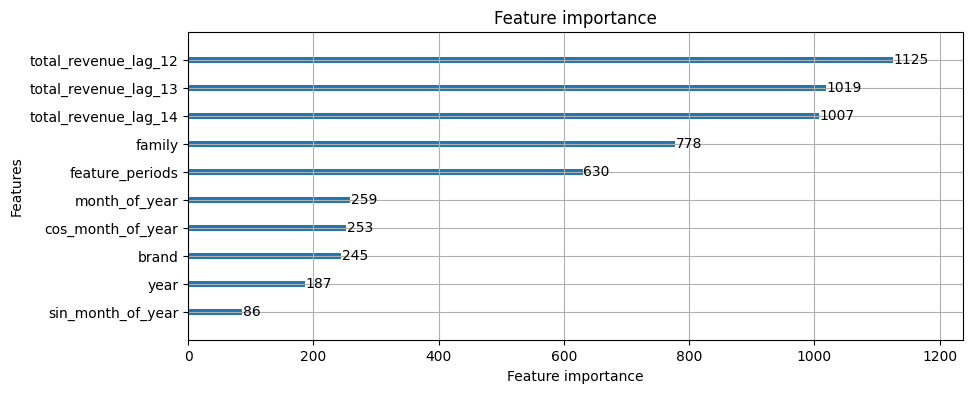

In [18]:
fc_model.plot_feature_importance()

In [19]:
# X_train, X_test, y_train, y_test = utils_preprocessing.train_test_split(df_monthly, forecasting_horizon=12, target_col="y")

In [20]:
# fc_model = LightGBMForecastingModel(hyperparameters=optimal_params)
# fc_model.train(X_train, y_train)

### Plot predictions

In [21]:
y_preds = fc_model.predict(X=X_test)
df_preds = pd.DataFrame(
    data={
        "brand": X_test["brand"],
        "family": X_test["family"],
        "y_pred": y_preds,
        "y": y_test.values
    },
    index=X_test.index,
)

In [22]:
df_preds.index.min()

Timestamp('2023-09-30 00:00:00')

In [23]:
df_preds.index.max()

Timestamp('2024-08-31 00:00:00')

<Axes: xlabel='date'>

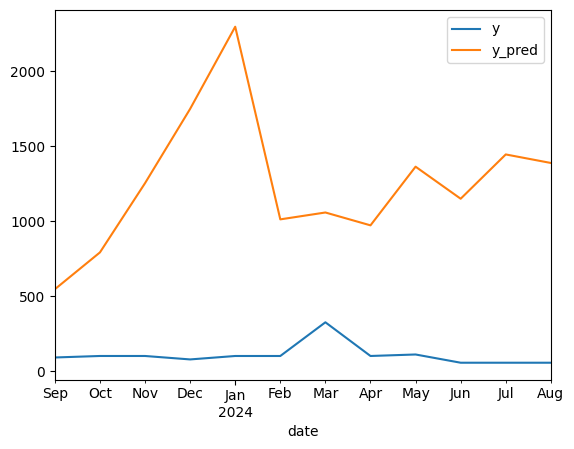

In [24]:
family = "Calcetines Running"
brand = "adidas"
df_preds[(df_preds["family"] == family) & (df_preds["brand"] == brand)][["y", "y_pred"]].plot()

In [25]:
df_preds[(df_preds["family"] == family) & (df_preds["brand"] == brand)][["y", "y_pred"]]

,y,y_pred
date,,
2023-09-30,90.000000,545.661744
2023-10-31,100.000000,791.539315
2023-11-30,100.000000,1253.782568
2023-12-31,77.000000,1749.820546
2024-01-31,99.949997,2298.352082
2024-02-29,99.949997,1012.125097
2024-03-31,324.950012,1058.034779
2024-04-30,100.000000,972.180932
2024-05-31,110.000000,1363.918582


In [26]:
df_monthly[["brand", "family"]].value_counts().head(50)

brand     family                                
adidas    Chándales Urban                           48
          Mallas y pantalones Running               48
          Chaquetas Outdoor                         48
Columbia  Polos Urban                               48
          Sandalias                                 48
adidas    Chaquetas Running                         48
Columbia  Zapatillas de montaña                     48
adidas    Bañadores Natación                        48
          Pantalones Urban                          48
          Botas de montaña                          48
          Calcetines Running                        48
          Calcetines Training                       48
          Outlet Zapatillas Urban                   48
          Outlet Zapatillas Running                 48
          Outlet Equipación Fitness                 48
          Camisetas Running                         48
          Camisetas Training                        48
          Camise